<a href="https://colab.research.google.com/github/Sukantanath108/Data-Science-and-ML-journey/blob/main/arrow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless


from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import math
import time

In [ ]:
# prompt: how to upload a image from my local computer

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving arrow.png to arrow (3).png
User uploaded file "arrow (3).png" with length 9750 bytes


In [ ]:
import os
file_path = os.path.join(os.getcwd(), 'arrow.png')  # Replace with your image filename
print(file_path)  # Display the full path


/content/arrow.png


In [ ]:
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image to isolate black arrows on white background
    _, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)

    return thresh

In [ ]:
def detect_arrow_contours(thresh_image):
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    arrow_contour = None
    for contour in contours:
        # Approximate the contour to simplify it
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # We assume the arrow has more than 5 vertices (complex shape)
        if len(approx) > 5:
            arrow_contour = approx
            break

    return arrow_contour

In [ ]:
def detect_arrow_direction(arrow_contour, image):
    if arrow_contour is None:
        return None, None

    # Draw the contour on the image (for visualization)
    cv2.drawContours(image, [arrow_contour], -1, (0, 255, 0), 2)

    # Compute the moments of the contour to get the center
    M = cv2.moments(arrow_contour)
    if M['m00'] == 0:
        return None, None
    cx = int(M['m10'] / M['m00'])  # x coordinate of center
    cy = int(M['m01'] / M['m00'])  # y coordinate of center

    # Calculate bounding box of the arrow contour
    rect = cv2.minAreaRect(arrow_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Arrow direction estimation based on bounding box orientation
    angle = rect[2]  # Angle of the rectangle

    # Determine the direction (N, E, S, W) based on the angle
    if -45 <= angle <= 45:
        direction = "Right"
    elif 45 < angle <= 135:
        direction = "Down"
    elif -135 <= angle < -45:
        direction = "Up"
    else:
        direction = "Left"

    return (cx, cy), direction

In [ ]:
def process_arrow_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Check if image loaded successfully
    if image is None:
        print(f"Error: Could not load image at {image_path}.Check if the file exists and the path is correct.")
        return None
        # Return None to indicate failure


    # Preprocess the image (thresholding, blurring, etc.)
    thresh_image = preprocess_image(image)

    # Detect arrow contours
    arrow_contour = detect_arrow_contours(thresh_image)

    # Detect the arrow's direction
    location, direction = detect_arrow_direction(arrow_contour, image)

    # Show results
    if location and direction:
        print(f"Arrow found at: {location}, Direction: {direction}")
    else:
        print("No arrow detected.")

    # Display the result image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return direction



GPS_BASED Navigation

In [ ]:
def get_current_gps_coordinates():
    # This function should return the current GPS location of the rover as (latitude, longitude)
    return (12.9715987, 77.594566)  # Dummy coordinates (Bangalore, India)


In [ ]:
def calculate_distance(coord1, coord2):
    # Haversine formula to calculate distance between two GPS coordinates
    R = 6371e3  # Earth radius in meters
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

In [ ]:
def calculate_bearing(coord1, coord2):
    # Calculate the bearing (direction) from current location to the next waypoint
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])

    dlon = lon2 - lon1

    x = math.sin(dlon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)

    bearing = math.degrees(math.atan2(x, y))

    return (bearing + 360) % 360  # Normalize bearing to [0, 360]

In [ ]:
def move_rover_to_gps(coordinates):
    target_gps = coordinates
    tolerance = 2  # Tolerance in meters

    while True:
        # Get current GPS coordinates
        current_gps = get_current_gps_coordinates()

        # Calculate distance to target
        distance_to_target = calculate_distance(current_gps, target_gps)

        if distance_to_target <= tolerance:
            print(f"Arrived at destination: {target_gps}")
            break

        # Calculate direction (bearing) to target
        bearing_to_target = calculate_bearing(current_gps, target_gps)

        # Send commands to the rover to move towards the target (replace with actual movement code)
        print(f"Moving towards target. Bearing: {bearing_to_target}°, Distance: {distance_to_target:.2f} meters")

        time.sleep(1)  # Simulate time delay for movement


Combine arrow detection and navigation

In [ ]:
# Function to map arrow direction to GPS offsets (e.g., move N, E, S, W based on direction)
def calculate_next_gps_from_direction(current_gps, direction):
    # Approximate small distance movement (e.g., 10 meters) based on direction
    lat, lon = current_gps
    distance_m = 10  # Move 10 meters in the direction of the arrow

    if direction == "Right":
        new_lon = lon + (distance_m / 111320)  # Longitude moves more slowly
        return (lat, new_lon)
    elif direction == "Left":
        new_lon = lon - (distance_m / 111320)
        return (lat, new_lon)
    elif direction == "Up":
        new_lat = lat + (distance_m / 110540)  # Latitude moves faster
        return (new_lat, lon)
    elif direction == "Down":
        new_lat = lat - (distance_m / 110540)
        return (new_lat, lon)

In [ ]:
def detect_and_navigate(image_path):
    # Detect arrow direction from image
    direction = process_arrow_image(image_path)

    if direction is None:
        print("No direction found, can't navigate.")
        return

    print(f"Detected direction: {direction}")

    # Get current GPS location of the rover
    current_gps = get_current_gps_coordinates()

    # Calculate the next GPS waypoint based on arrow direction
    next_gps = calculate_next_gps_from_direction(current_gps, direction)

    print(f"Next GPS waypoint: {next_gps}")

    # Move the rover to the next GPS location
    move_rover_to_gps(next_gps)

Arrow found at: (531, 539), Direction: Right


<ipython-input-60-5abad3179fab>:18: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


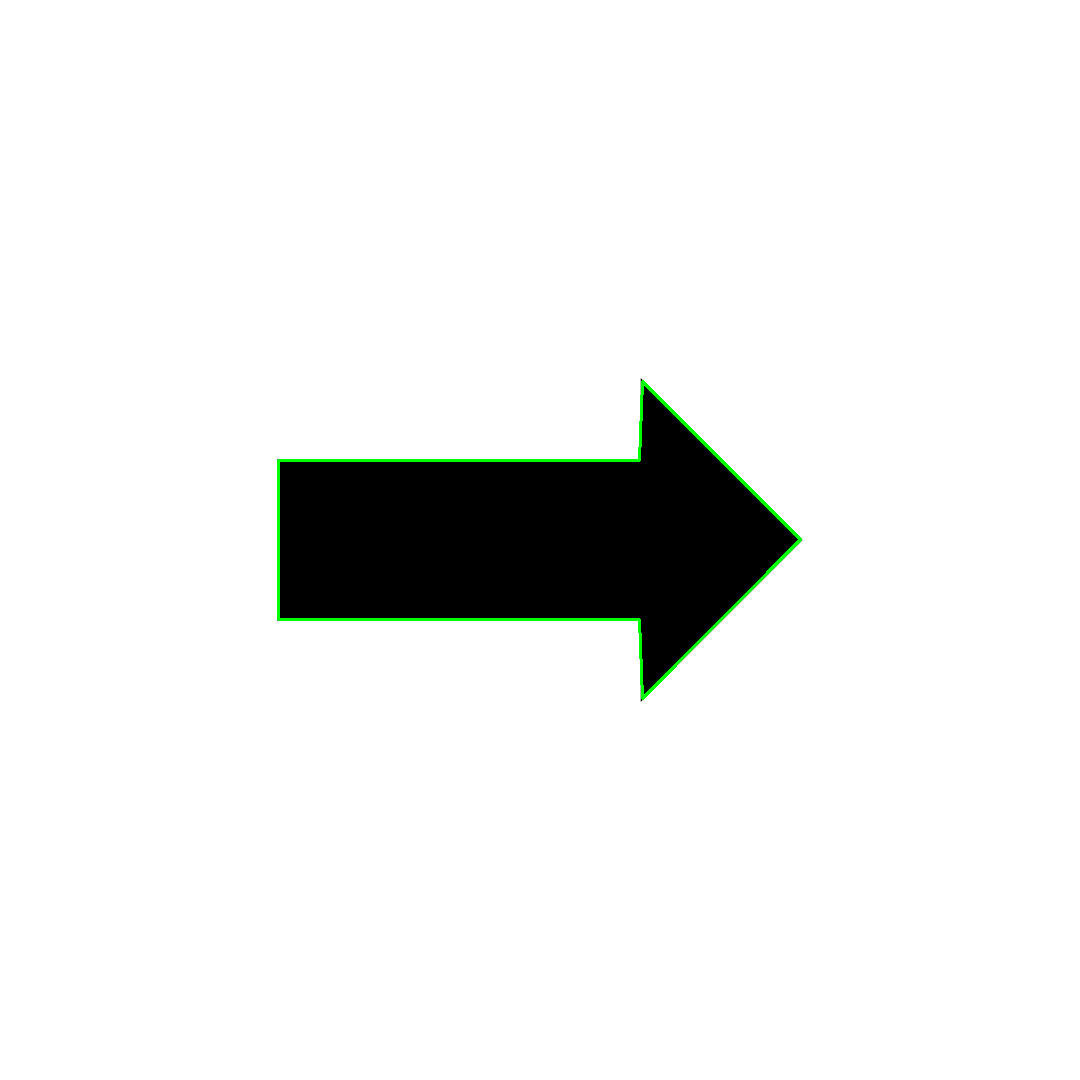

error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [ ]:
detect_and_navigate(file_path)